# Assignment 8: Data Aggregation and Group Operations

## Overview
This assignment covers data aggregation and group operations using healthcare/insurance EHR data. You'll analyze patient encounters (insurance claims), healthcare providers, and medical facilities across different regions. The data includes provider statistics, facility information, and encounter charges with insurance coverage details.

## Setup

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set random seed for reproducibility
np.random.seed(42)

# Create output directory
os.makedirs('output', exist_ok=True)

## Question 1: Basic GroupBy Operations

### Part 1.1: Load and Explore Data

**TODO: Load and merge the datasets**

In [105]:
# Load the three CSV files into dataframes
provider_df = pd.read_csv('data/provider_data.csv')
facility_df = pd.read_csv('data/facility_data.csv')
encounter_df = pd.read_csv('data/encounter_data.csv')

# Print the shapes of each dataframe
print("Provider data shape:", provider_df.shape)
print("Facility data shape:", facility_df.shape)
print("Encounter data shape:", encounter_df.shape)

# Merge the dataframes for analysis

# Drop duplicate region column, same between encounter and facility
encounter_df_mod = encounter_df.drop('region', axis = 1)

# Merge, keep encounter facility id, rename provider's
encounter_provider = pd.merge(
    encounter_df_mod, 
    provider_df, 
    on = 'provider_id', 
    how = 'left',
    suffixes = ('', '_provider')
    )

# Merge full data
merged_df = pd.merge(
    encounter_provider, 
    facility_df, 
    on = 'facility_id', 
    how = 'left'
    )


# Print the merged dataframe shape, columns, and first few rows
print("\nMerged data shape:\n", merged_df.shape)
print("\nColumns:\n", merged_df.columns)
print("\nFirst few rows:\n", merged_df.head())

Provider data shape: (500, 7)
Facility data shape: (10, 6)
Encounter data shape: (5000, 12)

Merged data shape:
 (5000, 22)

Columns:
 Index(['encounter_id', 'patient_id', 'provider_id', 'facility_id',
       'encounter_date', 'encounter_type', 'diagnosis_code', 'procedure_code',
       'service_charge', 'insurance_paid', 'patient_paid', 'provider_name',
       'provider_type', 'facility_id_provider', 'specialty',
       'years_experience', 'license_number', 'facility_name', 'facility_type',
       'region', 'beds', 'established_date'],
      dtype='object')

First few rows:
   encounter_id patient_id provider_id facility_id encounter_date  \
0     ENC00001   PAT01564      PR0259      FAC004     2023-08-21   
1     ENC00002   PAT00296      PR0258      FAC001     2023-09-11   
2     ENC00003   PAT01381      PR0213      FAC001     2023-03-20   
3     ENC00004   PAT01131      PR0146      FAC004     2023-09-03   
4     ENC00005   PAT01388      PR0354      FAC003     2023-06-14   

        

### Part 1.2: Basic Aggregation

**TODO: Perform basic groupby operations**

In [106]:
# TODO: Group by facility (healthcare facility) and calculate basic stats
# TODO: Calculate mean, sum, count for years_experience by facility
# TODO: Calculate total encounter charges by facility
# TODO: Calculate total insurance payments by facility
# TODO: Find the facility with highest total encounter charges

# Group by facility and calculate basic stats
merged_df.groupby('facility_name').agg({
    'years_experience' : ['mean', 'sum', 'count'],
    'service_charge' : 'sum',
    'insurance_paid' : 'sum',
})

# Find facility with highest total encounter charges
merged_df.groupby('facility_name')['service_charge'].sum().idxmax()

# Create a summary dataframe with one row per facility showing:
# facility_name, total_providers, avg_years_experience, total_service_charge, total_insurance_paid
sum_df = merged_df.groupby('facility_name').agg({
    'provider_id' : 'nunique',
    'years_experience' : 'mean',
    'service_charge' : 'sum',
    'insurance_paid' : 'sum'
})
sum_df = sum_df.rename(columns = {
    'provider_id' : 'total_providers',
    'years_experience' : 'avg_years_experience',
    'service_charge' : 'total_service_charge',
    'insurance_paid' : 'total_insurance_paid'  
}).reset_index()

# Save the summary dataframe as 'output/q1_groupby_analysis.csv'
sum_df.to_csv('output/q1_groupby_analysis.csv')

### Part 1.3: Transform Operations

**TODO: Use transform operations to add group statistics**

In [107]:
# TODO: Add facility mean years_experience as new column
# TODO: Add facility standard deviation of years_experience
# TODO: Create normalized years_experience (z-score within facility)
# TODO: Add facility total encounter charges as new column

merged_df['fm_years_experience'] = merged_df.groupby('facility_name')['years_experience'].transform('mean')
merged_df['fsd_years_experience'] = merged_df.groupby('facility_name')['years_experience'].transform('std')
merged_df['fn_years_experience'] = (merged_df['years_experience'] - merged_df['fm_years_experience']) / merged_df['fsd_years_experience']
merged_df['ft_encounter_charge'] = merged_df.groupby('facility_name')['service_charge'].transform('sum')

# TODO: Display the enhanced dataframe
display(merged_df)
# TODO: Save results as 'output/q1_aggregation_report.txt'
with open('output/q1_aggregation_report.txt', 'w') as File:
    "TO DO"

,encounter_id,patient_id,provider_id,facility_id,encounter_date,encounter_type,diagnosis_code,procedure_code,service_charge,insurance_paid,...,license_number,facility_name,facility_type,region,beds,established_date,fm_years_experience,fsd_years_experience,fn_years_experience,ft_encounter_charge
0,ENC00001,PAT01564,PR0259,FAC004,2023-08-21,Office Visit,M79.3,99213,345.03,290.33,...,LIC000259,Northside Urgent Care,Urgent Care,West,313,1994-10-04,20.137014,10.581439,-0.863495,297283.06
1,ENC00002,PAT00296,PR0258,FAC001,2023-09-11,Inpatient,N18.9,85025,550.48,482.51,...,LIC000258,City General Hospital,Urgent Care,South,276,1999-11-27,19.563008,10.702137,-0.052607,295508.13
2,ENC00003,PAT01381,PR0213,FAC001,2023-03-20,Lab,K21.9,80053,149.84,116.67,...,LIC000213,City General Hospital,Urgent Care,South,276,1999-11-27,19.563008,10.702137,-1.547636,295508.13
3,ENC00004,PAT01131,PR0146,FAC004,2023-09-03,Outpatient Procedure,H52.9,70450,1468.48,1198.71,...,LIC000146,Northside Urgent Care,Urgent Care,West,313,1994-10-04,20.137014,10.581439,-1.336020,297283.06
4,ENC00005,PAT01388,PR0354,FAC003,2023-06-14,Emergency,G43.9,99214,672.23,507.22,...,LIC000354,Regional Medical Center,Urgent Care,South,459,1982-05-10,20.209205,11.575935,1.364105,316284.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,ENC04996,PAT01045,PR0065,FAC002,2023-05-27,Emergency,K21.9,70450,5064.91,3932.06,...,LIC000065,Community Health Clinic,Urgent Care,North,160,2023-03-31,20.160784,11.044011,1.434191,334992.21
4996,ENC04997,PAT00658,PR0204,FAC004,2023-09-26,Lab,M79.3,99214,191.82,150.07,...,LIC000204,Northside Urgent Care,Urgent Care,West,313,1994-10-04,20.137014,10.581439,-0.485474,297283.06
4997,ENC04998,PAT01902,PR0174,FAC006,2023-04-25,Emergency,J44.9,80053,347.27,267.46,...,LIC000174,Oncology Treatment Center,Hospital,South,252,1994-03-19,19.381139,10.872386,-0.402960,334927.30
4998,ENC04999,PAT00925,PR0083,FAC006,2023-01-09,Lab,M79.3,99213,157.93,111.65,...,LIC000083,Oncology Treatment Center,Hospital,South,252,1994-03-19,19.381139,10.872386,0.424825,334927.30


## Question 2: Advanced GroupBy Operations

### Part 2.1: Filter Operations

**TODO: Use filter operations to remove groups**

In [108]:
# TODO: Filter facilities with more than 20 providers (sufficient staffing)
# TODO: Filter facilities with average years_experience > 10 (experienced staff)
# TODO: Filter facilities with total encounter charges > 250000 (high volume)

filtered = merged_df.groupby('facility_name').filter(lambda x: x['provider_id'].nunique() > 20)
filtered = filtered.groupby('facility_name').filter(lambda x: x['years_experience'].mean() > 10)
filtered = filtered.groupby('facility_name').filter(lambda x: x['service_charge'].sum() > 250000)

# TODO: Create a summary of filtered results
sum_df = filtered.groupby('facility_name').agg({
    'provider_id' : 'nunique',
    'years_experience' : 'mean',
    'service_charge' : 'sum',
    'insurance_paid' : 'sum'
})
sum_df = sum_df.rename(columns = {
    'provider_id' : 'total_providers',
    'years_experience' : 'avg_years_experience',
    'service_charge' : 'total_service_charge',
    'insurance_paid' : 'total_insurance_paid'  
}).reset_index()

# TODO: Save results as 'output/q2_filter_analysis.csv'
sum_df.to_csv('output/q2_filter_analysis.csv')

### Part 2.2: Apply Operations

**TODO: Use apply operations with custom functions**

In [109]:
# TODO: Create custom function to calculate provider statistics
def provider_stats(group):
    # TODO: Return mean, std, min, max, range for years_experience
    return {
        'mean' : group['years_experience'].mean(),
        'std' : group['years_experience'].std(),
        'min' : group['years_experience'].min(),
        'max' : group['years_experience'].max(),
        'range' : group['years_experience'].max() - group['years_experience'].min()
    }
    

# TODO: Apply custom function to each facility
# Note: Add include_groups=False to avoid pandas FutureWarning about groupby columns
facility_provider_stats = merged_df.groupby('facility_name').apply(provider_stats, include_groups=False)
print(facility_provider_stats)

# TODO: Create function to find top providers in each facility
def top_providers(group, n=2):
    """Return top n providers in a group by encounter volume"""
    # TODO: Return top n rows by encounter count, selecting only provider_id, provider_name, 
    #       years_experience, specialty
    return (group.groupby(['provider_id', 'provider_name', 'years_experience', 'specialty']).size().nlargest(n))

# TODO: Apply function to get top 2 providers per facility
# IMPORTANT: When using groupby().apply(), the result has a MultiIndex where:
# - Level 0: The grouping column (facility_name)
# - Level 1: The original row index from each group
# Use reset_index(level=0) to move only the grouping column back to a regular column
# DO NOT use reset_index(drop=True) - that would drop ALL index levels including facility_name!
top_providers_by_facility = merged_df.groupby('facility_name').apply(
    lambda x: top_providers(x, n=2)
).reset_index(level=0)  # Moves facility_name from index to column
print(top_providers_by_facility)

# TODO: Save results as 'output/q2_performance_report.txt'
with open('output/q2_performance_report.txt', 'w') as File:
    "TO DO"

facility_name
Cardiology Specialty Center    {'mean': 19.31972789115646, 'std': 10.48461192...
City General Hospital          {'mean': 19.5630081300813, 'std': 10.702137018...
Community Health Clinic        {'mean': 20.16078431372549, 'std': 11.04401051...
Emergency Medical Center       {'mean': 19.66868686868687, 'std': 11.02386669...
Northside Urgent Care          {'mean': 20.137014314928425, 'std': 10.5814386...
Oncology Treatment Center      {'mean': 19.3811394891945, 'std': 10.872386004...
Pediatric Care Center          {'mean': 19.811676082862522, 'std': 10.9992424...
Primary Care Clinic            {'mean': 20.102970297029703, 'std': 11.0771684...
Regional Medical Center        {'mean': 20.209205020920503, 'std': 11.5759346...
Surgical Specialty Center      {'mean': 20.778181818181817, 'std': 11.3581324...
dtype: object
                                                                                facility_name  \
provider_id provider_name    years_experience specialty          

/var/folders/q2/425x2zhd1b3f3hnjp4v223880000gn/T/ipykernel_34864/2748578432.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_providers_by_facility = merged_df.groupby('facility_name').apply(


### Part 2.3: Hierarchical Grouping

**TODO: Perform multi-level grouping**

In [110]:
# TODO: Group by facility type and region
# TODO: Calculate statistics for each facility_type-region combination
# TODO: Use unstack to convert to wide format
# TODO: Use stack to convert back to long format

hierarchical = merged_df.groupby(['facility_type', 'region']).agg({
    'provider_id' : 'nunique',
    'years_experience' : 'mean',
    'service_charge' : 'sum',
    'insurance_paid' : 'sum' 
})
hierarchical = hierarchical.rename(columns = {
    'provider_id' : 'total_providers',
    'years_experience' : 'avg_years_experience',
    'service_charge' : 'total_service_charge',
    'insurance_paid' : 'total_insurance_paid'  
})

wide_hierarchical = hierarchical.unstack()
long_hierarchical = wide_hierarchical.stack()

# TODO: Analyze the hierarchical structure
print("Wide Hierarchical Dimensions:\n", wide_hierarchical.shape)
print("Long Hierarchical Dimensions:\n", long_hierarchical.shape)

# TODO: Save results as 'output/q2_hierarchical_analysis.csv'
hierarchical.to_csv('output/q2_hierarchical_analysis.csv')

Wide Hierarchical Dimensions:
 (3, 12)
Long Hierarchical Dimensions:
 (6, 4)


/var/folders/q2/425x2zhd1b3f3hnjp4v223880000gn/T/ipykernel_34864/3074968491.py:20: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long_hierarchical = wide_hierarchical.stack()


## Question 3: Pivot Tables and Cross-Tabulations

### Part 3.1: Basic Pivot Tables

**TODO: Create pivot tables for multi-dimensional analysis**

In [111]:
# TODO: Create pivot table: encounter charges by procedure code and region
pivot = pd.pivot_table(
    data = merged_df,
    values = 'service_charge',
    index = 'procedure_code',
    columns = 'region',
    aggfunc = 'sum'
)
print(pivot)
# TODO: Create pivot table with multiple aggregations (sum, mean, count)
pivot2 = pd.pivot_table(
    data = merged_df,
    values = 'service_charge',
    index = 'procedure_code',
    columns = 'region',
    aggfunc = ['sum', 'mean', 'count'],
)
# TODO: Add totals (margins) to pivot table
pivot3 = pd.pivot_table(
    data = merged_df,
    values = 'service_charge',
    index = 'procedure_code',
    columns = 'region',
    aggfunc = ['sum', 'mean', 'count'],
    margins = True,
    margins_name = 'Total'
)
# TODO: Handle missing values with fill_value
pivot4 = pd.pivot_table(
    data = merged_df,
    values = 'service_charge',
    index = 'procedure_code',
    columns = 'region',
    aggfunc = ['sum', 'mean', 'count'],
    margins = True,
    margins_name = 'Total',
    fill_value = 0
)

# Tip: When saving a pivot table to CSV, the index (row labels) is preserved by default.
#      This is usually desired - when reading back, use index_col=0 to restore the index.
# TODO: Save results as 'output/q3_pivot_analysis.csv'
pivot4.to_csv('output/q3_pivot_analysis.csv')

region             North      South       West
procedure_code                                
36415           12130.35   57836.97   48458.05
70450           90236.85  375893.20  312204.53
70551           52844.83  234817.26  160891.32
72040           11463.33   81039.58   56599.39
80053           14798.09   83849.78   58540.39
85025            8946.57   48989.64   40769.13
93000            6743.28   55873.35   45845.38
99213           62143.42  327262.66  259242.79
99214           71684.08  322532.05  240095.41
99283            4001.41   31172.21   24520.39


### Part 3.2: Cross-Tabulations

**TODO: Create cross-tabulations for categorical analysis**

In [112]:
# TODO: Create crosstab of facility type vs region with counts
cross = pd.crosstab(
    index = merged_df['facility_type'],
    columns = merged_df['region']
)

# TODO: Create crosstab with margins (row and column totals)
cross2 = pd.crosstab(
    index = merged_df['facility_type'],
    columns = merged_df['region'],
    margins = True
)
# TODO: Create multi-dimensional crosstab showing facility type × encounter type × region combinations
#       (Hint: use pd.crosstab with multiple index/column parameters, or create manually from the data)
cross3 = pd.crosstab(
    index = [merged_df['facility_type'], merged_df['encounter_type']],
    columns = merged_df['region'],
    margins = True
)
# TODO: Analyze the cross-tabulation results
print(cross3)
# TODO: Save results as 'output/q3_crosstab_analysis.csv'
cross3.to_csv('output/q3_crosstab_analysis.csv')

region                                 North  South  West   All
facility_type    encounter_type                                
Hospital         Emergency                 0    127     0   127
                 Inpatient                 0     95     0    95
                 Lab                       0    100     0   100
                 Office Visit              0     85     0    85
                 Outpatient Procedure      0    102     0   102
Specialty Center Emergency                 0    236   182   418
                 Inpatient                 0    210   191   401
                 Lab                       0    211   180   391
                 Office Visit              0    175   200   375
                 Outpatient Procedure      0    194   193   387
Urgent Care      Emergency               109    190   195   494
                 Inpatient                90    190   201   481
                 Lab                      90    229   228   547
                 Office Visit           

### Part 3.3: Pivot Table Visualization

**TODO: Create visualizations from pivot tables**

<Axes: xlabel='procedure_code', ylabel='service_charge'>

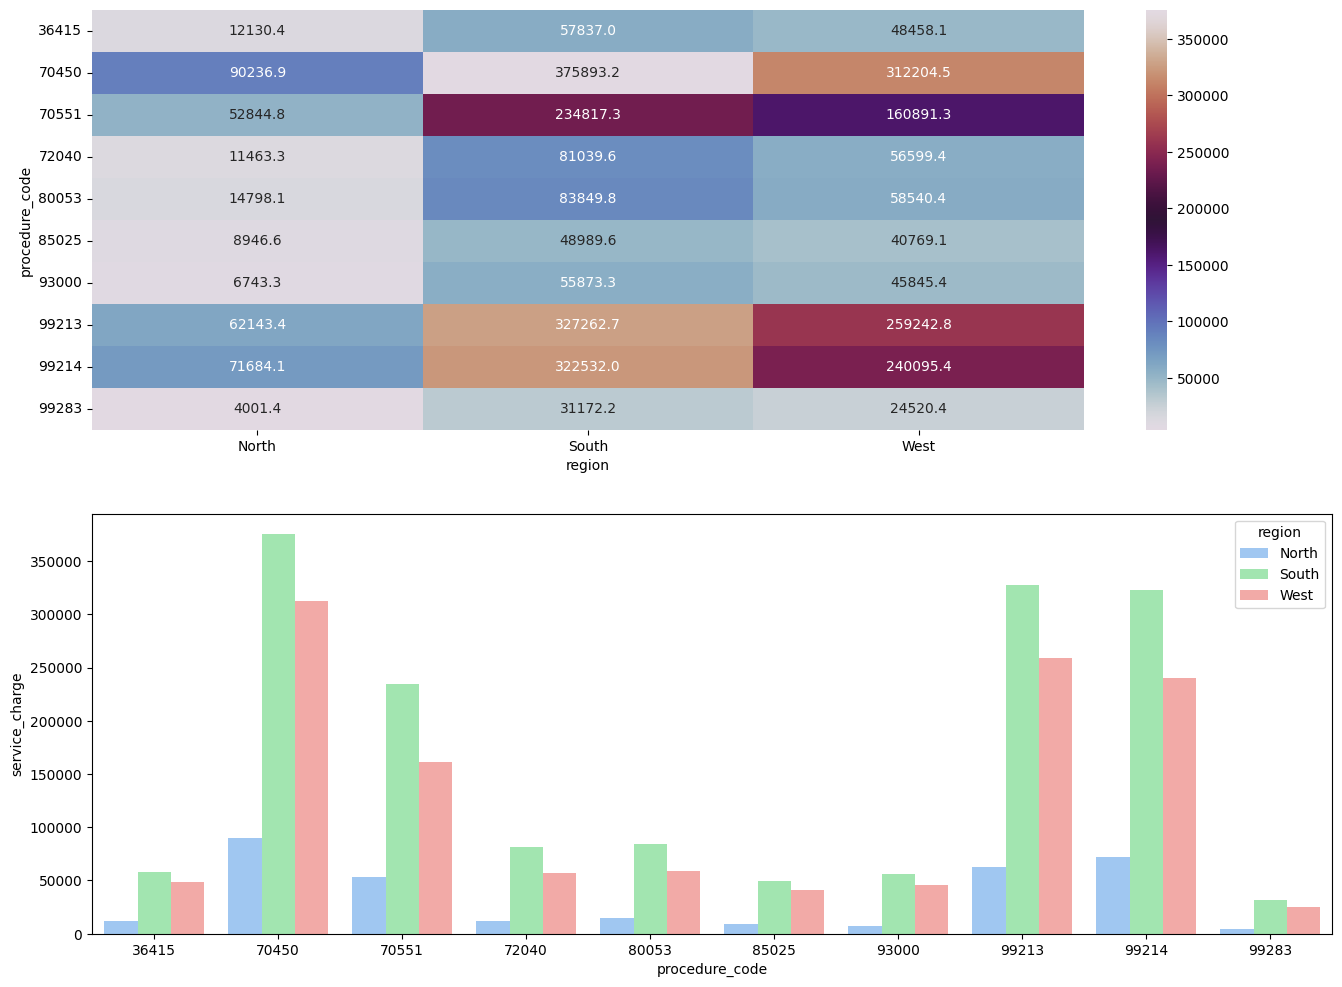

In [113]:
plt.style.use('seaborn-v0_8-pastel')
fig, axes = plt.subplots(2, 1, figsize = (16, 12))
# TODO: Create heatmap from pivot table

sns.heatmap(
    data = pivot,
    annot = True,
    cmap = "twilight",
    fmt = '.1f',
    ax = axes[0]
)
# TODO: Create bar chart from pivot table
sns.barplot(
    data = pivot.reset_index().melt(
        id_vars = 'procedure_code',
        var_name = 'region',
        value_name = 'service_charge'
    ),
    x = 'procedure_code',
    y = 'service_charge',
    hue = 'region',
    ax = axes[1]
)
# TODO: Customize colors and styling
# TODO: Add appropriate titles and labels

# TODO: Save the plot as 'output/q3_pivot_visualization.png'

## Submission Checklist

Before submitting, verify you've created:

- [ ] `output/q1_groupby_analysis.csv` - Basic groupby analysis
- [ ] `output/q1_aggregation_report.txt` - Aggregation report
- [ ] `output/q2_filter_analysis.csv` - Filter operations analysis
- [ ] `output/q2_hierarchical_analysis.csv` - Hierarchical analysis
- [ ] `output/q2_performance_report.txt` - Performance report
- [ ] `output/q3_pivot_analysis.csv` - Pivot table analysis
- [ ] `output/q3_crosstab_analysis.csv` - Cross-tabulation analysis
- [ ] `output/q3_pivot_visualization.png` - Pivot visualization

## Key Learning Objectives

- Master the split-apply-combine paradigm
- Apply aggregation functions and transformations
- Create pivot tables for multi-dimensional analysis
- Apply advanced groupby techniques